In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm
from PIL import Image
import sklearn.decomposition
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [2]:
# Download Faces Data
import requests, zipfile, io, os

url = 'https://osf.io/2kyfb/download'

fname = 'faces'

if not os.path.exists(fname+'zip'):
    print("Data is being downloaded...")
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print("The download has been completed.")
else:
    print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


45


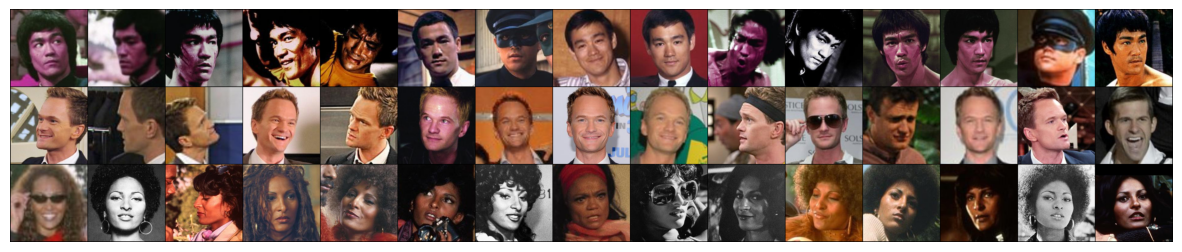

In [3]:
# Display Images
# Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)
print(image_count)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [4]:
face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=True)
dataiter = iter(face_loader)
images, labels = next(dataiter)

In [5]:
X_train = images[:40, :, :, :]
X_test = images[40:, :, :, :]
y_train = labels[:40]
y_test = labels[40:]

In [6]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        pass
    
    def forward(self, x):
        raise NotImplementedError
    
    def train_net(self, X_train, y_train, epochs=1, batchSize=50):
        # define cross entropy loss function
        loss_fn = self.loss_fn
        # define an optimizer for computing gradients
        optimizer = self.optimizer
        
        for i in range(epochs):
            for j in range(math.ceil(len(X_train) / batchSize)):
                X = X_train[j*batchSize:(j+1)*batchSize]
                y = y_train[j*batchSize:(j+1)*batchSize]
                
                y_pred = self.forward(Variable(torch.FloatTensor(X)))
                try:
                    y = torch.from_numpy(y).type(torch.LongTensor)
                except:
                    y = y.type(torch.LongTensor)
                loss = loss_fn(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)

In [8]:
def conv2d(x, W, stride, bias=None):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, bias, stride=stride, padding=2)

# Defining a Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, classes=10, n=5):
        super(CNNClassifer, self).__init__()
        
        self.weight1 = weight_variable((n, 3, 5, 5))
        self.bias1 = bias_variable((n))
        self.weight2 = weight_variable((2 * n, n, 5, 5))
        self.bias2 = bias_variable((2 * n))
        self.weight3 = weight_variable((64, 2 * n * 64 * 64))
        self.bias3 = bias_variable((64))
        self.weight4 = weight_variable((classes, 64))
        self.bias4 = bias_variable((classes))
        self.relu = nn.ReLU()
        
        # define cross entropy loss function
        self.loss_fn = nn.CrossEntropyLoss(reduction='sum')
        
        # define an optimizer for computing gradients
        learning_rate = 1e-3
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
       
    def forward(self, x):
        conv1 = conv2d(x, self.weight1, 2, bias=self.bias1)
        conv1_relu = self.relu(conv1)
        conv2 = conv2d(conv1_relu, self.weight2, 2, bias=self.bias2)
        conv2_relu = self.relu(conv2)
        hidden = torch.addmm(self.bias3, conv2_relu.view(list(conv2_relu.size())[0], -1), self.weight3.t())
        hidden_relu = self.relu(hidden)
        y = torch.addmm(self.bias4, hidden_relu.view(list(hidden_relu.size())[0], -1), self.weight4.t())
        return y

In [20]:
# Create and initialize the CNN Classifier Model
cnnClassifer = CNNClassifer(classes=3)

# Train the CNN Classifier Model
cnnClassifer.train_net(X_train, y_train, epochs=1000, batchSize=15)

In [21]:
def DataBatch(data, label, batchsize, shuffle=True):
    """
    This function provides a generator for batches of data that 
    yields data (batchsize, 3, 32, 32) and labels (batchsize)
    if shuffle, it will load batches in a random order
    """
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

In [22]:
def Confusion_Matrix(testData, testLabels, classifier):
    batchsize=50
    correct=0
    M=np.zeros((3,3))
    num=testData.shape[0]/batchsize
    count=0
    acc=0
    
    for data,label in tqdm(DataBatch(testData,testLabels,batchsize,shuffle=False),\
                           total=len(testData)//batchsize):
        prediction = classifier(data)
        for i in range(len(label)):
            M[label[i], prediction[i]] += 1
            if prediction[i] == label[i]:
                acc += 1
            count += 1
    for row in M:
        row /= sum(row)
    
    return M,acc*100.0/len(testData)

def Visualize_Confusion_Matrix(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

1it [00:00,  4.55it/s]

CNN classifier accuracy: 100.000000


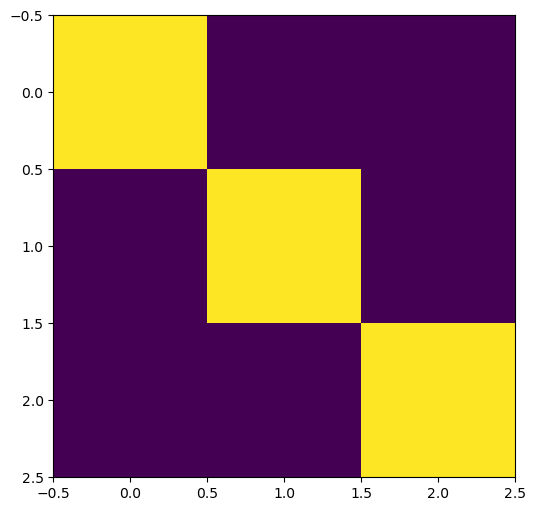

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [23]:
# Print the test accuracy and plot the confusion matrix of the CNN Classifier
M_cnn, acc_cnn = Confusion_Matrix(X_test, y_test, cnnClassifer)
print ('CNN classifier accuracy: %f'%acc_cnn)
Visualize_Confusion_Matrix(M_cnn)

In [13]:
# !pip install facenet-pytorch --quiet
# !pip install Pillow --quiet
import glob
from facenet_pytorch import MTCNN, InceptionResnetV1

In [14]:
# Image Preprocessing Function
def process_images(image_dir: str, size=256):
    mtcnn = MTCNN(image_size=size, margin=32)
    images = []
    for img_path in glob.glob(image_dir):
        img = Image.open(img_path)
        # Normalize and crop image
        img_cropped = mtcnn(img)
        images.append(img_cropped)

    model_tensor = torch.stack(images)
    display_tensor = model_tensor / (model_tensor.max() * 2)
    display_tensor += .5

    return model_tensor, display_tensor

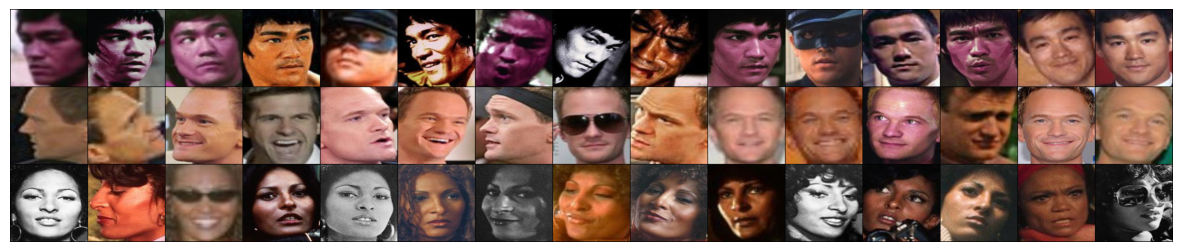

In [15]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [16]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [17]:
DEVICE = set_device()
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)
# Calculate embedding
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(DEVICE))
neil_embeddings = resnet(neil_tensor.to(DEVICE))
pam_embeddings = resnet(pam_tensor.to(DEVICE))

In [18]:
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

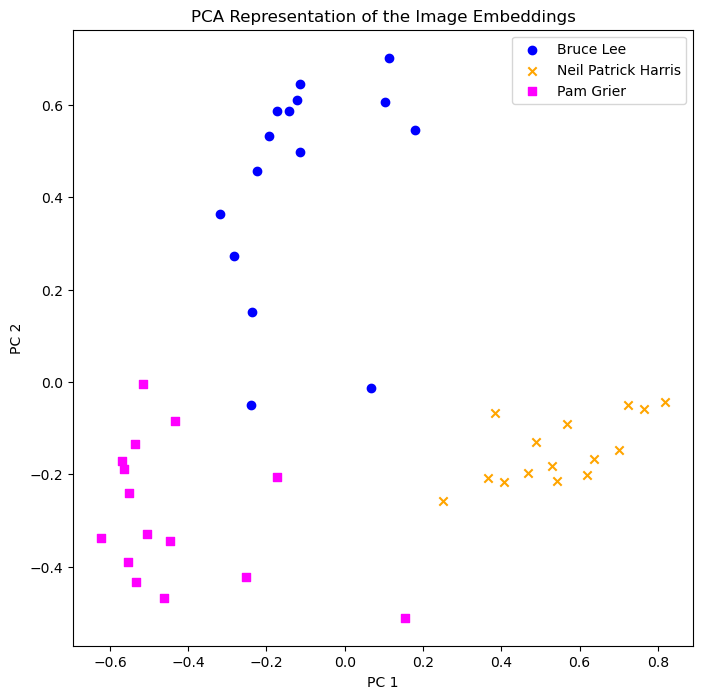

In [19]:
num = 15
categs = 3
colors = ['blue', 'orange', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier']
markers = ['o', 'x', 's']
plt.figure(figsize=(8, 8))
for i in range(categs):
    plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()